In [1]:
%load_ext autoreload
%autoreload 2

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint, LinearConstraint, Bounds

import data_utils
import plots
import truncated_normal, normal
import deltas
import projection
import radius
import cvxpy as cp

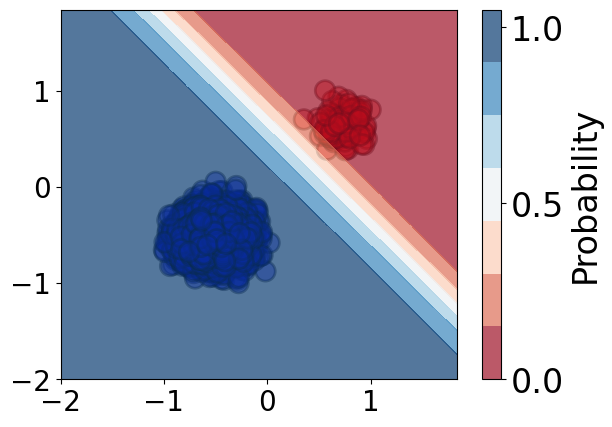

In [2]:
m1 = [1, 1]
m2 = [10, 10]

cov1 = [[1, 0], [0, 1]]
cov2 = [[5, 0], [0, 5]]
cov2 = cov1

N1 = 10000
N2 = 100
scale = True

data = normal.get_two_classes(means=[m1, m2], 
                              covs=[cov1, cov2],
                              num_samples=[N1, N2])
scaler = data_utils.normaliser(data)
if scale == True:
    data = scaler(data)
    m1 = scaler.transform_instance(m1)
    m2 = scaler.transform_instance(m2)

clf = SVC(random_state=0, probability=True,
          kernel='linear').fit(data['X'], data['y'])

clf = LogisticRegression().fit(data['X'], data['y'])

ax, _ = plots._get_axes(None)
plots.plot_classes(data, ax=ax)
plots.plot_decision_boundary(clf, data, ax=ax)
plots.plt.show()

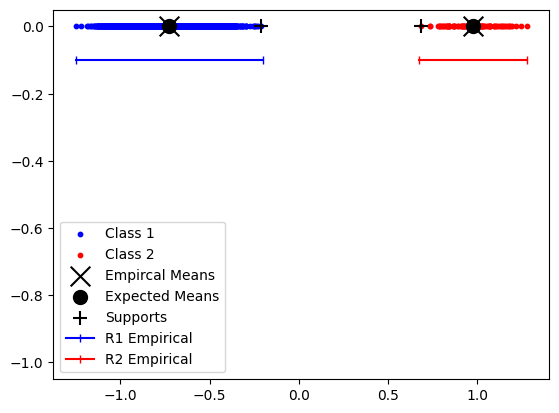

In [3]:
# get projections
proj_data = projection.from_clf(data, clf, supports=True)
proj_means = projection.from_clf({'X': np.array([m1, m2]), 'y': [0, 1]}, clf)

# Empircal M
M_emp = np.abs(proj_data['supports'][1]-proj_data['supports'][0]).squeeze()

# get Rs
R_sup = radius.supremum(data['X'])
R_sup = radius.supremum(proj_data['X'])
# empirical means
xp1, xp2 = projection.get_classes(proj_data)
emp_xp1, emp_xp2 = projection.get_emp_means(proj_data)
R1_emp = radius.supremum(proj_data['X1'], emp_xp1)
R2_emp = radius.supremum(proj_data['X2'], emp_xp2)

# plot
ax = plots.plot_projection(proj_data, proj_means, R1_emp, R2_emp)

In [4]:
# Costs
c1 = 1
c2 = 1

In [5]:
# use scipy
bounds = [(0, 1)]
delta1_init = (0.5)
delta1_init = (np.random.uniform())
use_grad = True
if use_grad == True:
    func = deltas.scipy_optim_func
else:
    func = deltas.loss_one_delta

# set up contraints
def eq_8(delta):
    return deltas.contraint(N1, N2, delta[0], R_sup, M_emp)

def con_real(delta):
    return np.sum(np.iscomplex(delta))

def delta_less_1(delta):
    return delta[0] - 1

def delta_greater_1(delta):
    return delta[0] - 1

contrs = [{'type':'eq', 'fun': eq_8},
          {'type':'eq', 'fun': con_real},
        #   {'type': 'ineq', 'fun': eq_8} 
          ]

# contrs = [NonlinearConstraint(eq_8, 0, 0),   # 0, 0  to say equality
        #   LinearConstraint([[1]], 0.2, 1-0.2)
        #   ]

res = minimize(func,
               delta1_init,
               (c1, c2, N1, N2, M_emp, R_sup), 
               #    method='SLSQP',
               bounds=Bounds([0], [1]),
               jac=use_grad,  # use gradient
               constraints=contrs
               )

delta1 = res.x
# delta1 = np.array([0.000000000000000000001])
delta2 = deltas.delta2_given_delta1(N1, N2, M_emp, delta1, R_sup)
print(f'delta1 : {delta1[0]} \ndelta2: {delta2[0]}')
print(f'eq.8 constraint: {eq_8(delta1)} should equal 0')

delta1 : 1e-21 
delta2: 0.3115163804956859
eq.8 constraint: 0.11950124378879112 should equal 0


R1_est : 0.6747261189082714 
R2_est: 0.7527488889137206


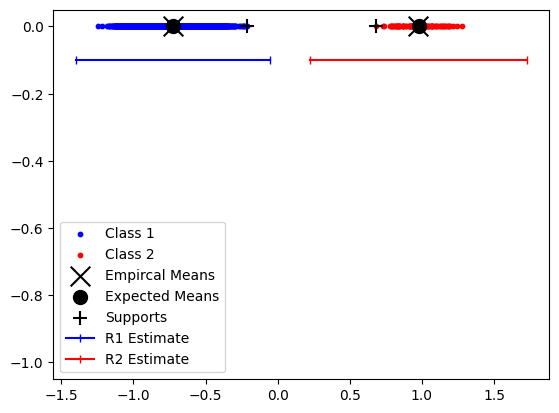

In [6]:
# calculate each R upper bound
R1_est = radius.R_upper_bound(R1_emp, R_sup, N1, delta1)
R2_est = radius.R_upper_bound(R2_emp, R_sup, N2, delta2)
print(f'R1_est : {R1_est[0]} \nR2_est: {R2_est[0]}')
ax = plots.plot_projection(proj_data, proj_means, R1_est, R2_est, R_est=True)

In [7]:
D_emp = np.abs(emp_xp1 - emp_xp2)
D = np.abs(proj_means['X1'] - proj_means['X2'])

print('comparing D values (distance between means)')
print(f'Empircal D : {D_emp}')
print(f'Expected D : {D[0][0]}')

D_from_deltas = R1_est + R2_est
print(f'Eq. 7    D : {D_from_deltas[0]}')

print(f'contraint eq. 8 = {deltas.contraint(N1, N2, delta1, R_sup, M_emp)[0]}')

comparing D values (distance between means)
Empircal D : 1.6995218026223267
Expected D : 1.7021270711766294
Eq. 7    D : 1.427475007821992
contraint eq. 8 = 0.11950124378879112
